In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rasterio
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import math
import datetime
# import gdal
# from google.colab import drive
# drive.mount('/content/drive')
# base ='/content/drive/My Drive/'

In [127]:
os.getcwd()
os.chdir('/home/shoyo/Desktop')

In [128]:
# Set seed
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

In [129]:
csv_path = '/SOClandsat6mTrue.csv'
df = pd.read_csv(os.getcwd() + csv_path)
df = df.drop(columns=['latitude', 'longitude', 'year'])
df

,SOC,bushland,cropland,forest,grassland,mangrove,shrubland,thicket,wooded_grassland,woodland,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,EVI,ST_B10
0,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.265025,0.339853,0.344527,0.471247,0.429887,0.360505,0.201174,296.367932
1,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098526,0.177355,0.185976,0.389586,0.352255,0.251646,0.290177,295.665529
2,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166671,0.191600,0.207811,0.356407,0.213353,0.192645,0.228537,236.222743
3,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391195,0.382739,0.383000,0.508249,0.305120,0.206890,0.068306,283.094052
4,6.84225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246600,0.280232,0.284247,0.357961,0.203893,0.175059,0.167163,233.638720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14683,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040075,0.102803,0.092655,0.342272,0.235930,0.179720,0.358089,270.165391
14684,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169545,0.206367,0.209172,0.452987,0.324095,0.270855,0.424340,268.008620
14685,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030257,0.082178,0.073377,0.405440,0.212115,0.121035,0.391282,288.103160
14686,13.22570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055791,0.132709,0.108825,0.415835,0.256349,0.170576,0.473930,276.779260


In [131]:
scaler = MinMaxScaler()
# train_df = df[0:int(n*0.8)]
# val_df = df[int(n*0.8):int(n*0.9)]
# test_df = df[int(n*0.9):]
train_df = scaler.fit_transform(df[:11760])
val_df = scaler.fit_transform(df[11760:(11760+1464)])
test_df = scaler.fit_transform(df[(11760+1464):])



In [132]:
print(
    np.std(train_df), np.max(train_df), np.min(train_df)
)

0.28753969679178026 1.0 0.0


In [133]:
n = len(df)

Xtrain = train_df[:,1:]
Xtrain = Xtrain.reshape((  int(len(Xtrain)/6), 6, 17))
Ytrain = train_df[:,0][::6]
Ytrain = Ytrain.reshape((len(Ytrain),1))

Xval = val_df[:,1:]
Xval = Xval.reshape((  int(len(Xval)/6), 6, 17))
Yval = val_df[:,0][::6]
Yval = Yval.reshape((len(Yval),1))

Xtest = test_df[:,1:]
Xtest = Xtest.reshape((  int(len(Xtest)/6), 6, 17))
Ytest = test_df[:,0][::6]
Ytest = Ytest.reshape((len(Ytest),1))

num_features = df.shape[1]

# train_mean = train_df.mean()
# train_std = train_df.std()
# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

In [134]:
batch_size = 128
units = 32
units_dense = 1  # labels are of one dimension
lr = 0.001
epochs = 30

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units, input_shape=(6, 17), dropout=0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units_dense, activation='linear')])

2023-05-03 16:19:14.507784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 16:19:14.509609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 16:19:14.510755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [135]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            metrics=[tf.keras.metrics.MeanAbsoluteError(), 
                     tf.keras.metrics.RootMeanSquaredError()
                    ])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='LSTM',
                                                      update_freq='epoch',
                                                      profile_batch=0)

history = model.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,validation_data=(Xval, Yval), callbacks=[tensorboard_callback])

Epoch 1/30


2023-05-03 16:19:16.759758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 16:19:16.761806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 16:19:16.763296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/16 [===========================>..] - ETA: 0s - loss: 0.1464 - mean_absolute_error: 0.2886 - root_mean_squared_error: 0.3826

2023-05-03 16:19:19.042753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 16:19:19.044802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 16:19:19.046264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 3s 45ms/step - loss: 0.1446 - mean_absolute_error: 0.2865 - root_mean_squared_error: 0.3802 - val_loss: 0.1377 - val_mean_absolute_error: 0.3207 - val_root_mean_squared_error: 0.3711
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 0.0291 - mean_absolute_error: 0.1339 - root_mean_squared_error: 0.1706 - val_loss: 0.1301 - val_mean_absolute_error: 0.3093 - val_root_mean_squared_error: 0.3607
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 0.0200 - mean_absolute_error: 0.1022 - root_mean_squared_error: 0.1413 - val_loss: 0.1083 - val_mean_absolute_error: 0.2745 - val_root_mean_squared_error: 0.3291
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 0.0149 - mean_absolute_error: 0.0869 - root_mean_squared_error: 0.1219 - val_loss: 0.1124 - val_mean_absolute_error: 0.2811 - val_root_mean_squared_error: 0.3353
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss

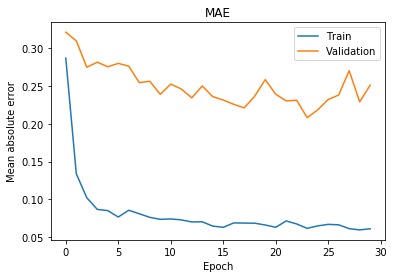

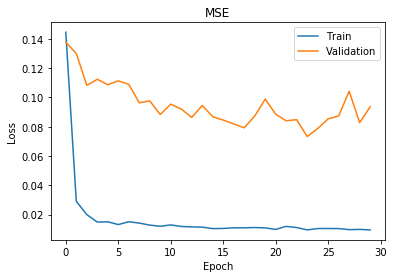

In [137]:
# Plot the training and validation accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE')
plt.ylabel('Mean absolute error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [82]:
Ypred = model.predict(Xtest)

1/8 [==>...........................] - ETA: 2s

2023-05-03 16:12:05.356322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 16:12:05.358144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 16:12:05.359409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 0s 3ms/step


In [83]:
mse = mean_squared_error(Ypred, Ytest)
print("RMSE", math.sqrt(mse))
mae = mean_absolute_error(Ypred, Ytest)
print("MAE", mae)
R_square = r2_score(Ypred, Ytest) 
print('Coefficient of Determination', R_square) 

RMSE 1.0892179118726617
MAE 0.8640352461705394
Coefficient of Determination -7.875172763092392


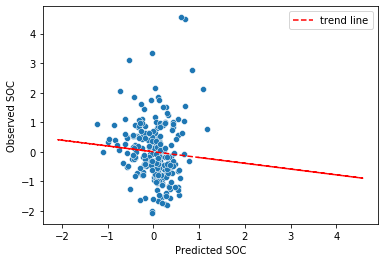

In [84]:
scatterplot=sns.scatterplot(x=np.squeeze(Ypred), y=np.squeeze(Ytest))
z = np.polyfit(np.squeeze(Ypred), np.squeeze(Ytest), 1)  #Least squares polynomial fit.
p = np.poly1d(z)                           #A one-dimensional polynomial class.
scatterplot.plot(np.squeeze(Ytest), p(np.squeeze(Ytest)), "r--", label='trend line')
plt.legend()
plt.xlabel("Predicted SOC")
plt.ylabel("Observed SOC")
plt.show()

In [ ]:
rf = RandomForestRegressor()
